# Punto 3

## Librerías utilizadas

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from tqdm.notebook import tqdm
import warnings
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve, auc, classification_report
from sklearn.model_selection import train_test_split
import time
from tqdm import tqdm
import joblib
from bayes_opt import BayesianOptimization

warnings.filterwarnings("ignore")


In [7]:
full_data = pd.read_csv('train_transaction.csv')
full_data.columns

data = full_data[['TransactionID','TransactionDT', 'TransactionAmt', 'C3', 'C5', 'card4', 'card6', 'isFraud', 'card3', 'card2']]
data

,TransactionID,TransactionDT,TransactionAmt,C3,C5,card4,card6,isFraud,card3,card2
0,2987000,86400,68.50,0.0,0.0,discover,credit,0,150.0,NaN
1,2987001,86401,29.00,0.0,0.0,mastercard,credit,0,150.0,404.0
2,2987002,86469,59.00,0.0,0.0,visa,debit,0,150.0,490.0
3,2987003,86499,50.00,0.0,0.0,mastercard,debit,0,150.0,567.0
4,2987004,86506,50.00,0.0,0.0,mastercard,credit,0,150.0,514.0
...,...,...,...,...,...,...,...,...,...,...
590535,3577535,15811047,49.00,0.0,1.0,visa,debit,0,150.0,NaN
590536,3577536,15811049,39.50,0.0,0.0,mastercard,debit,0,150.0,225.0
590537,3577537,15811079,30.95,0.0,1.0,mastercard,debit,0,150.0,595.0
590538,3577538,15811088,117.00,0.0,0.0,mastercard,debit,0,150.0,481.0


In [8]:
data['isFraud'] = data['isFraud'].astype(bool)
data['card6'] = data['card6'].map({'credit': True, 'debit': False})

card4_dummies = pd.get_dummies(data['card4'], prefix='card4')

data.drop('card4', axis=1, inplace=True)
data = pd.concat([data, card4_dummies], axis=1)

data.to_csv('dataF.csv', index=False)
data.head()

,TransactionID,TransactionDT,TransactionAmt,C3,C5,card6,isFraud,card3,card2,card4_american express,card4_discover,card4_mastercard,card4_visa
0,2987000,86400,68.5,0.0,0.0,True,False,150.0,NaN,False,True,False,False
1,2987001,86401,29.0,0.0,0.0,True,False,150.0,404.0,False,False,True,False
2,2987002,86469,59.0,0.0,0.0,False,False,150.0,490.0,False,False,False,True
3,2987003,86499,50.0,0.0,0.0,False,False,150.0,567.0,False,False,True,False
4,2987004,86506,50.0,0.0,0.0,True,False,150.0,514.0,False,False,True,False


Luego de realizar el EDA de estos conjuntos de datos se decidió ajustar los modelos predictivos con las siguientes variables:

- Variables explicativas: TransactionDT, TransactionAmt, C3, C5, card4, card6, isFraud, card3, card2
- Variable respuesta: isFraud

Como ya tenemos establecido cuál será el conjunto de datos que utilizaremos para entrenar los modelos de clasificación, procedemos a construir el Pipeline. Además, escogió una validación cruzada estratificada ya que nos interesa que en cada partición quede la misma proporción de etiquetas.

In [4]:
data = pd.read_csv('dataF.csv')

## Balanceo de datos usando Undersampling

Iniciamos balanceando el conjunto de datos usando undersampling.

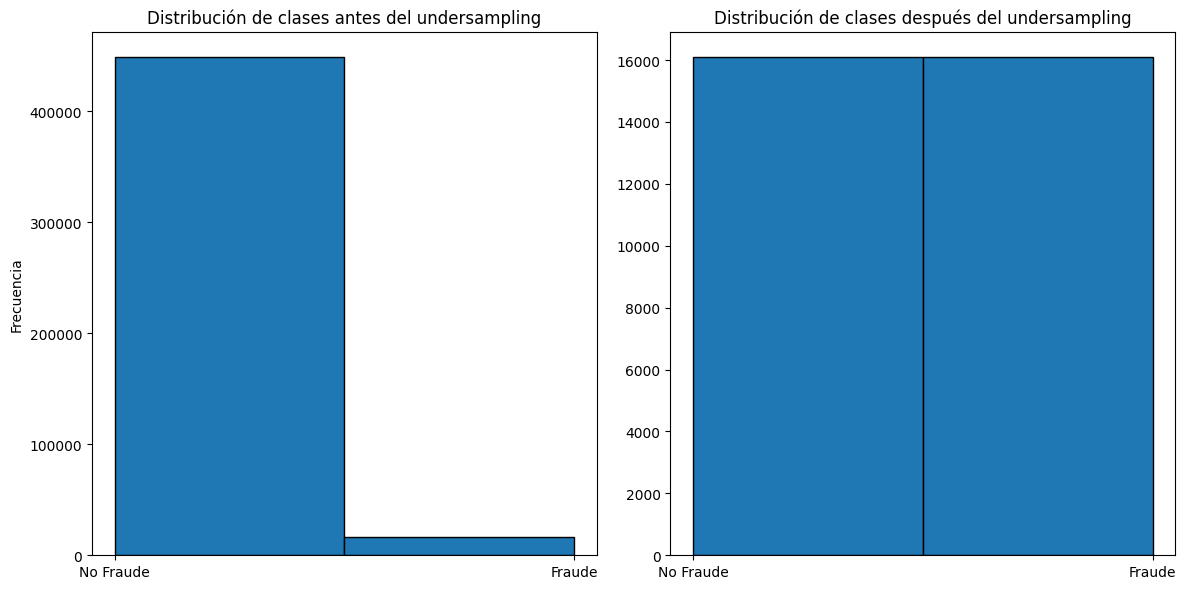

Distribución de clases después del undersampling:
isFraud
False    16106
True     16106
Name: count, dtype: int64


In [9]:
data = data.dropna()

X = data.drop(columns=['isFraud'])
y = data['isFraud']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rus = RandomUnderSampler(random_state=42)
X_train_resampled, y_train_resampled = rus.fit_resample(X_train, y_train)

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

axs[0].hist(y_train.astype(int), bins=2, edgecolor='k')  
axs[0].set_title('Distribución de clases antes del undersampling')
axs[0].set_xticks([0, 1])
axs[0].set_xticklabels(['No Fraude', 'Fraude'])
axs[0].set_ylabel('Frecuencia')

axs[1].hist(y_train_resampled.astype(int), bins=2, edgecolor='k')  
axs[1].set_title('Distribución de clases después del undersampling')
axs[1].set_xticks([0, 1])
axs[1].set_xticklabels(['No Fraude', 'Fraude'])

plt.tight_layout()
plt.show()

print("Distribución de clases después del undersampling:")
print(y_train_resampled.value_counts())


Observamos la distribución de las clases antes y después de realizar el balanceo.

## Entrenamiento del modelo usando Gridsearch y Pipeline

  0%|          | 0/2 [00:00<?, ?it/s]

Fitting 5 folds for each of 6 candidates, totalling 30 fits


 50%|█████     | 1/2 [00:25<00:25, 25.78s/it]

Fitting 5 folds for each of 9 candidates, totalling 45 fits


100%|██████████| 2/2 [3:46:48<00:00, 6804.36s/it]


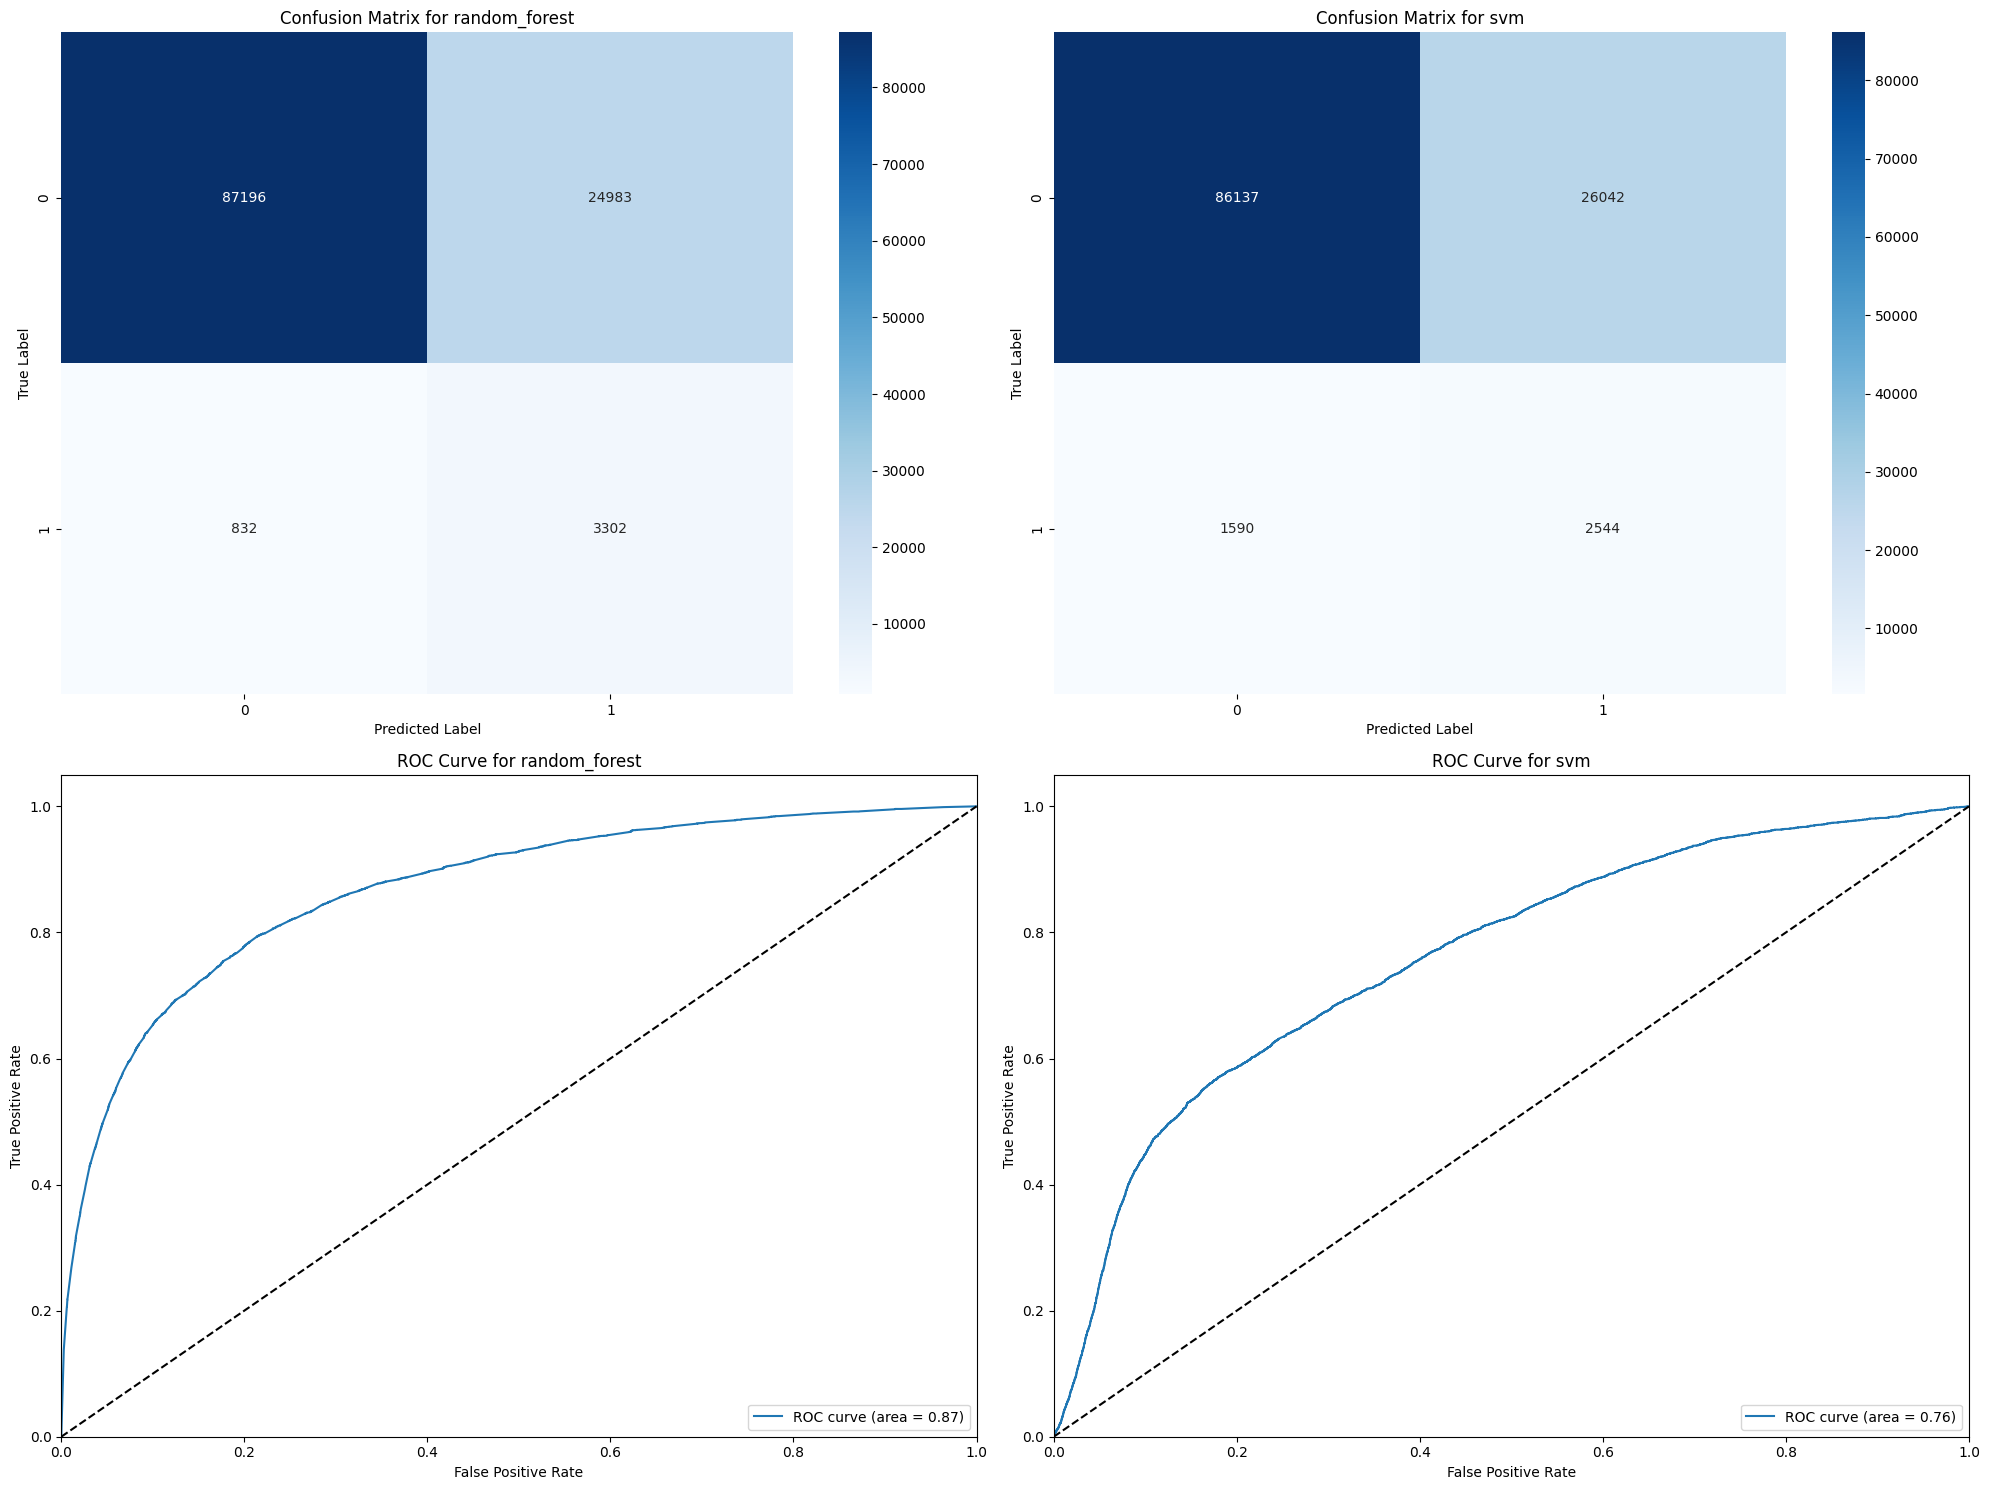

,Model,Precision,Recall,F1-score,AUC,Best Parameters,Elapsed Time
0,random_forest,0.116740,0.798742,0.203708,0.868157,"{'random_forest__max_depth': 30, 'random_fores...",23.852691
1,svm,0.088995,0.615385,0.155501,0.759603,"{'svm__C': 10, 'svm__gamma': 0.1, 'svm__kernel...",12842.818414


In [10]:
pipelines = {
    'random_forest': Pipeline([
        ('scaler', StandardScaler()),
        ('random_forest', RandomForestClassifier(random_state=2))
    ]),
    'svm': Pipeline([
        ('scaler', StandardScaler()),
        ('svm', SVC(probability=True))
    ])
}

param_grid = {
    'random_forest': {
        'random_forest__n_estimators': [5, 10, 50],
        'random_forest__max_depth': [20, 30]
    },
    'svm': {
        'svm__C': [0.1, 1, 10],
        'svm__gamma': [0.1, 0.01, 0.001],
        'svm__kernel': ['rbf']
    }
}

results = []
trained_models = {}

fig, axes = plt.subplots(2, 2, figsize=(20, 15)) 

for i, model in enumerate(tqdm(pipelines)):
    start_time = time.time()  
    grid_search = GridSearchCV(pipelines[model], param_grid[model], cv=StratifiedKFold(n_splits=5), scoring='roc_auc', verbose=1)
    grid_search.fit(X_train_resampled, y_train_resampled)  
    end_time = time.time()  

    trained_models[model] = grid_search.best_estimator_

    y_pred = grid_search.best_estimator_.predict(X_test)
    y_prob = grid_search.best_estimator_.predict_proba(X_test)[:, 1]  
    
    cm = confusion_matrix(y_test, y_pred)
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    results.append({
        'Model': model,
        'Precision': precision,
        'Recall': recall,
        'F1-score': f1,
        'AUC': roc_auc,
        'Best Parameters': grid_search.best_params_,
        'Elapsed Time': end_time - start_time
    })

    ax1 = axes[i // 2, i % 2]  
    sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', ax=ax1)
    ax1.set_title(f"Confusion Matrix for {model}")
    ax1.set_ylabel('True Label')
    ax1.set_xlabel('Predicted Label')

    ax2 = axes[(i // 2) + 1, i % 2]  
    ax2.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
    ax2.plot([0, 1], [0, 1], 'k--')
    ax2.set_xlim([0.0, 1.0])
    ax2.set_ylim([0.0, 1.05])
    ax2.set_xlabel('False Positive Rate')
    ax2.set_ylabel('True Positive Rate')
    ax2.set_title(f'ROC Curve for {model}')
    ax2.legend(loc="lower right")

plt.tight_layout()  
plt.show()

results_table = pd.DataFrame(results)
results_table.to_pickle('results_table.pkl')

joblib.dump(trained_models, 'trained_models.pkl')
results_table

Random Forest muestra un mejor rendimiento general en términos de recall, F1-score y AUC, además de ser mucho más eficiente en términos de tiempo de ejecución. SVM por su parte tiene una precisión y AUC inferiores y requiere mucho más tiempo para ejecutarse.
Estos resultados sugieren que, en este caso, el Random Forest es el modelo más adecuado.

## Optimización Bayesiana

Realizamos la optimización bayesiana para encontrar los mejores hiperparámetros.

In [10]:
def svm_cv(C, gamma, kernel_idx):
    kernel_list = ['rbf']
    kernel = kernel_list[int(kernel_idx)]
    clf = SVC(C=C, gamma=gamma, kernel=kernel, probability=True)
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('svm', clf)
    ])
    c_val = cross_val_score(pipeline, X_train_resampled, y_train_resampled, scoring='roc_auc', cv=StratifiedKFold(n_splits=5), verbose=1)
    return c_val.mean()

param_bounds = {
    'C': (0.1, 10), 
    'gamma': (0.0001, 1),
    'kernel_idx': (0, 0) 
}


optimizer = BayesianOptimization(
    f=svm_cv,
    pbounds=param_bounds,
    random_state=1,
)


optimizer.maximize(init_points=2, n_iter=10)

print(optimizer.max)


|   iter    |  target   |     C     |   gamma   | kernel... |
-------------------------------------------------------------
| 1         | 0.7642    | 4.229     | 0.7204    | 0.0       |
| 2         | 0.7546    | 3.093     | 0.1468    | 0.0       |
| 3         | 0.7645    | 3.821     | 0.7899    | 0.0       |
| 4         | 0.7661    | 5.178     | 1.0       | 0.0       |
| 5         | 0.7626    | 5.698     | 0.3605    | 0.0       |
| 6         | 0.766     | 5.126     | 0.961     | 0.0       |
| 7         | 0.7678    | 9.974     | 0.9797    | 0.0       |
| 8         | 0.7463    | 9.65      | 0.04117   | 0.0       |
| 9         | 0.7669    | 6.861     | 1.0       | 0.0       |
| 10        | 0.7606    | 7.225     | 0.1886    | 0.0       |
| 11        | 0.7665    | 6.152     | 0.9995    | 0.0       |
| 12        | 0.7475    | 0.1       | 1.0       | 0.0       |
{'target': 0.7678000062404582, 'params': {'C': 9.97440550958843, 'gamma': 0.9796875218997422, 'kernel_idx': 0.0}}


Ahora, entrenamos el modelo con los mejores hiperparámetros encontrados.

Modelo 'Random Forest' guardado en 'Random Forest_model.pkl'
Modelo 'SVC' guardado en 'SVC_model.pkl'

Resultados para el modelo Random Forest:

Reporte de Clasificación:
{'False': {'precision': 0.9896588546057439, 'recall': 0.7848616942565008, 'f1-score': 0.8754424690768803, 'support': 112179.0}, 'True': {'precision': 0.11752230510457803, 'recall': 0.7774552491533624, 'f1-score': 0.20418016644431738, 'support': 4134.0}, 'accuracy': 0.7845984541710729, 'macro avg': {'precision': 0.5535905798551609, 'recall': 0.7811584717049316, 'f1-score': 0.5398113177605989, 'support': 116313.0}, 'weighted avg': {'precision': 0.9586613522144565, 'recall': 0.7845984541710729, 'f1-score': 0.8515844449602036, 'support': 116313.0}}

Matriz de Confusión:
[[88045 24134]
 [  920  3214]]

AUC: 0.861726460414213
Tiempo de cómputo: 10.428754568099976 segundos

Resultados para el modelo SVC:

Reporte de Clasificación:
{'False': {'precision': 0.9644988220728079, 'recall': 0.9999821713511442, 'f1-score': 0.9819200

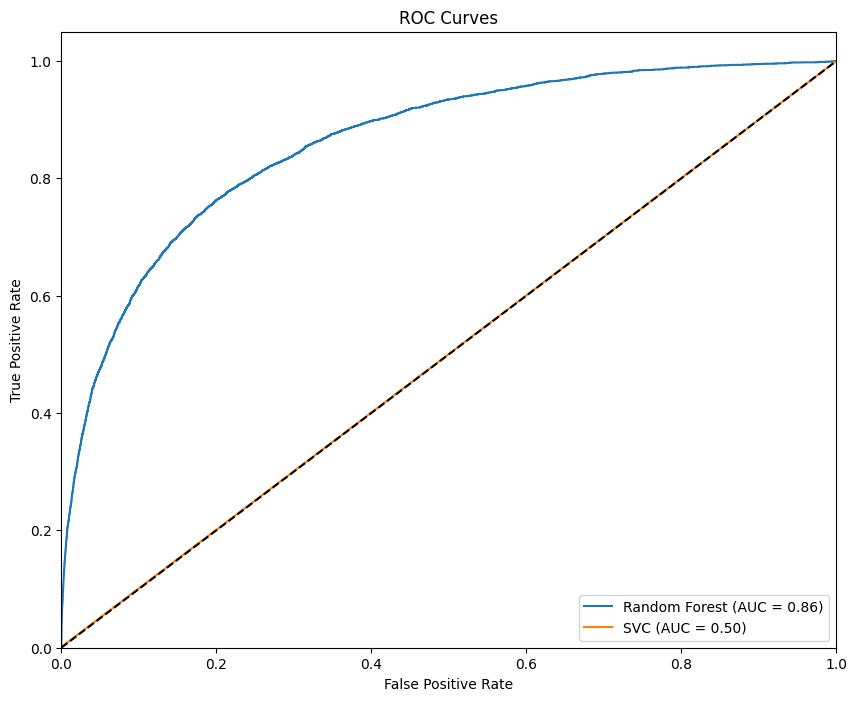

In [11]:
optimized_params = {'target': 0.7678000062404582, 'params': {'C': 9.97440550958843, 'gamma': 0.9796875218997422, 'kernel_idx': 0.0}}

models = {
    'Random Forest': RandomForestClassifier(
        n_estimators=int(94.22),
        max_depth=20,
        min_samples_split=2,
        min_samples_leaf=1,
        max_features=0.1,
        random_state=42
    ),
    'SVC': SVC(
        C=optimized_params['params']['C'],
        kernel='rbf',
        gamma=optimized_params['params']['gamma'],
        probability=True,
        random_state=42
    )
}

results = {}
roc_curves = []

for name, model in models.items():
    start_time = time.time()
    model.fit(X_train_resampled, y_train_resampled) 
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None
    elapsed_time = time.time() - start_time
    
    results[name] = {
        'Report': classification_report(y_test, y_pred, output_dict=True),
        'Confusion Matrix': confusion_matrix(y_test, y_pred),
        'AUC': roc_auc_score(y_test, y_proba) if y_proba is not None else None,
        'Time': elapsed_time
    }
    
    if y_proba is not None:
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        roc_curves.append((fpr, tpr, name))

for name, model in models.items():
    model_filename = f'{name}_model.pkl'
    joblib.dump(model, model_filename)
    print(f"Modelo '{name}' guardado en '{model_filename}'")

joblib.dump((results, roc_curves), 'results_and_roc_curves.pkl')

for name, metrics in results.items():
    print(f"\nResultados para el modelo {name}:\n")
    print("Reporte de Clasificación:")
    print(metrics['Report'])
    print("\nMatriz de Confusión:")
    print(metrics['Confusion Matrix'])
    print(f"\nAUC: {metrics['AUC']}")
    print(f"Tiempo de cómputo: {metrics['Time']} segundos")

plt.figure(figsize=(10, 8))
for fpr, tpr, name in roc_curves:
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc_score(y_test, models[name].predict_proba(X_test)[:, 1]):.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend(loc="lower right")
plt.show()


Random Forest es claramente superior en términos de balance entre precisión, recall y AUC, especialmente para la clase positiva. Además, es mucho más rápido. 

Mientras que SVC muestra un alto rendimiento en precisión y recall para la clase negativa, pero falla en capturar la clase positiva y es significativamente más lento. Además, el rendimiento de este modelo empeoró luego de aplicarle optimización bayesiana.

En conclusión el mejor modelo para este conjunto de datos es Random Forest.

In [5]:
import numpy as np
import pandas as pd
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import BayesianRidge, Ridge, Lasso
from sklearn.metrics import mean_squared_error
import warnings
import ssl
ssl._create_default_https_context = ssl._create_unverified_context
warnings.filterwarnings("ignore")

wind = pd.read_csv("https://raw.githubusercontent.com/lihkir/Data/main/wind_speed/data_treino_dv_df_2000_2010.csv")

columnas = {'HORA (UTC)': 'hora', 'VENTO, DIREï¿½ï¿½O HORARIA (gr) (ï¿½ (gr))': 'direccion_viento', 
            'VENTO, VELOCIDADE HORARIA (m/s)': 'velocidad_viento', 'UMIDADE REL. MAX. NA HORA ANT. (AUT) (%)': 'humedad_max',
            'UMIDADE REL. MIN. NA HORA ANT. (AUT) (%)': 'humedad_min', 'TEMPERATURA Mï¿½XIMA NA HORA ANT. (AUT) (ï¿½C)': 'temperatura_max',
            'TEMPERATURA Mï¿½NIMA NA HORA ANT. (AUT) (ï¿½C)': 'temperatura_min', 'UMIDADE RELATIVA DO AR, HORARIA (%)': 'humedad_horaria',
            'PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)': 'pres_atmosferica', 'PRECIPITAï¿½ï¿½O TOTAL, HORï¿½RIO (mm)': 'precipitacion_hora',
            'VENTO, RAJADA MAXIMA (m/s)': 'rafaga_max', 'PRESSï¿½O ATMOSFERICA MAX.NA HORA ANT. (AUT) (mB)': 'pres_atmosferica_max', 'PRESSï¿½O ATMOSFERICA MIN. NA HORA ANT. (AUT) (mB)': 'pres_atmosferica_min'}
wind = wind.rename(columns=columnas)

X = wind.drop(columns=['velocidad_viento', 'hora'])
y = wind['velocidad_viento']
time_windows = [7, 14, 21, 28]

# Verificar los índices
for T in time_windows:
    for start in range(len(X) - T, T):
        end = start + T
        
        print(f"Ventana T={T}:")
        print(f"Índices de entrenamiento: {list(range(start, end))}")
        print(f"Índices de prueba: {list(range(end, end + 1))}")
        print("---")
